In [1]:
import numpy as np
import pandas as pd

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#spacy
import spacy

#vis
import pyLDAvis
import pyLDAvis.gensim_models

# plotting
import matplotlib.pyplot as plt

In [2]:
# convert excel file to pandas dataframe then exract text in shape of list of lists

df = pd.read_excel('Pubmed5k.xlsx', engine='openpyxl')
data = df['Abstract'].to_list()

In [3]:
# first topic
data[0]

'Coordination variability (CV) is commonly analyzed to understand dynamical qualities of human locomotion. The purpose of this study was to develop guidelines for the number of trials required to inform the calculation of a stable mean lower limb CV during overground locomotion. Three-dimensional lower limb kinematics were captured for 10 recreational runners performing 20 trials each of preferred and fixed speed walking and running. Stance phase CV was calculated for 9 segment and joint couplings using a modified vector coding technique. The number of trials required to achieve a CV mean within 10% of 20 strides average was determined for each coupling and individual. The statistical outputs of mode (walking vs running) and speed (preferred vs fixed) were compared when informed by differing numbers of trials. A minimum of 11 trials were required for stable mean stance phase CV. With fewer than 11 trials, CV was underestimated and led to an oversight of significant differences between 

In [4]:
# processing text through elimination of stop words and lemmatization 
def lemmatization(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    texts_out = []
    for text in texts:
        doc = nlp(text)
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags:
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    return (texts_out)


lemmatized_texts = lemmatization(data)

In [5]:
lemmatized_texts[0]

'coordination variability commonly analyze understand dynamical quality human locomotion purpose study develop guideline number trial require inform calculation stable mean low limb cv overground locomotion dimensional low limb kinematic capture recreational runner perform trial preferred fix speed walk running stance phase cv calculate segment joint coupling use modify vector code technique number trial require achieve cv mean % stride average determine coupling individual statistical output mode walk vs run speed prefer vs fix compare inform differ number trial minimum trial require stable mean stance phase cv few trial underestimate lead oversight significant difference mode speed future overground locomotion cv research healthy population use vector code approach use trial standard minimum researcher aware notable consequence insufficient number trial overall study finding'

In [6]:
# tokenizing strings to list of strings
def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True, max_len=30)
        final.append(new)
    return final

data_words = gen_words(lemmatized_texts)

In [7]:
data_words[0]

['coordination',
 'variability',
 'commonly',
 'analyze',
 'understand',
 'dynamical',
 'quality',
 'human',
 'locomotion',
 'purpose',
 'study',
 'develop',
 'guideline',
 'number',
 'trial',
 'require',
 'inform',
 'calculation',
 'stable',
 'mean',
 'low',
 'limb',
 'cv',
 'overground',
 'locomotion',
 'dimensional',
 'low',
 'limb',
 'kinematic',
 'capture',
 'recreational',
 'runner',
 'perform',
 'trial',
 'preferred',
 'fix',
 'speed',
 'walk',
 'running',
 'stance',
 'phase',
 'cv',
 'calculate',
 'segment',
 'joint',
 'coupling',
 'use',
 'modify',
 'vector',
 'code',
 'technique',
 'number',
 'trial',
 'require',
 'achieve',
 'cv',
 'mean',
 'stride',
 'average',
 'determine',
 'coupling',
 'individual',
 'statistical',
 'output',
 'mode',
 'walk',
 'vs',
 'run',
 'speed',
 'prefer',
 'vs',
 'fix',
 'compare',
 'inform',
 'differ',
 'number',
 'trial',
 'minimum',
 'trial',
 'require',
 'stable',
 'mean',
 'stance',
 'phase',
 'cv',
 'few',
 'trial',
 'underestimate',
 'lead'

In [8]:
# second step in preprocessing is to get bigrams and maybe trigrams
bigram_phrases = gensim.models.Phrases(data_words, min_count=3, threshold=100)
trigram_phrases = gensim.models.Phrases(bigram_phrases[data_words], min_count=3, threshold=100)

bigram = gensim.models.phrases.Phraser(bigram_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

def make_bigrams(texts):
    return([bigram[doc] for doc in texts])

def make_trigrams(texts):
    return ([trigram[bigram[doc]] for doc in texts])

data_bigrams = make_bigrams(data_words)
data_bigrams_trigrams = make_trigrams(data_bigrams)

In [9]:
trigram[data_words[0]]

['coordination',
 'variability',
 'commonly',
 'analyze',
 'understand',
 'dynamical',
 'quality',
 'human',
 'locomotion',
 'purpose',
 'study',
 'develop',
 'guideline',
 'number',
 'trial',
 'require',
 'inform',
 'calculation',
 'stable',
 'mean',
 'low',
 'limb',
 'cv',
 'overground',
 'locomotion',
 'dimensional',
 'low',
 'limb_kinematic',
 'capture',
 'recreational',
 'runner',
 'perform',
 'trial',
 'preferred',
 'fix',
 'speed',
 'walk',
 'running',
 'stance_phase',
 'cv',
 'calculate',
 'segment',
 'joint',
 'coupling',
 'use',
 'modify',
 'vector',
 'code',
 'technique',
 'number',
 'trial',
 'require',
 'achieve',
 'cv',
 'mean',
 'stride',
 'average',
 'determine',
 'coupling',
 'individual',
 'statistical',
 'output',
 'mode',
 'walk',
 'vs',
 'run_speed',
 'prefer',
 'vs',
 'fix',
 'compare',
 'inform',
 'differ',
 'number',
 'trial',
 'minimum',
 'trial',
 'require',
 'stable',
 'mean',
 'stance_phase',
 'cv',
 'few',
 'trial',
 'underestimate',
 'lead',
 'oversight',


In [10]:
# third and final step in preprocessing is to get rid of ubiquitous words through tf-idf
from gensim.models import TfidfModel

id2word = corpora.Dictionary(data_bigrams_trigrams)

texts = data_bigrams_trigrams

corpus = [id2word.doc2bow(text) for text in texts]


tfidf = TfidfModel(corpus, id2word=id2word)

low_value = 0.03
words  = []
words_missing_in_tfidf = []
for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = [] #reinitialize to be safe. You can skip this.
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words+words_missing_in_tfidf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow

In [11]:
# training model with chosen number of topics based on coherence score 
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=6, random_state=100, update_every=1, chunksize=100,
                                           passes=10, alpha="auto", minimum_probability=0)

In [12]:
# visualization
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.020598  0.293959       1        1  21.012097
5      0.031018 -0.305507       2        1  18.121357
0     -0.278833  0.171572       3        1  18.107270
3      0.281581  0.179833       4        1  17.138713
4      0.278393 -0.126606       5        1  16.722231
1     -0.291561 -0.213251       6        1   8.898332, topic_info=            Term         Freq        Total Category  logprob  loglift
169      patient  5057.000000  5057.000000  Default  30.0000  30.0000
385         cell  1795.000000  1795.000000  Default  29.0000  29.0000
296       health  1509.000000  1509.000000  Default  28.0000  28.0000
272    treatment  1686.000000  1686.000000  Default  27.0000  27.0000
121         risk  1602.000000  1602.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
1221      expose   140.346475   232.160540   Topic6  -5.7547   1.9160
420          new   181.859403   606.780638   Topic6  -5.4956   1.2144
106     increase   164.501624  1198.019927   Topic6  -5.5959   0.4338
3682  production   134.343831   332.164749   Topic6  -5.7984   1.5141
579     describe   135.830618   509.782325   Topic6  -5.7874   1.0967

[364 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
327       4  0.993606    access
1969      5  0.997431  accuracy
373       5  0.996333  accurate
0         3  0.164115   achieve
0         4  0.087717   achieve
...     ...       ...       ...
372       3  0.097099     woman
372       4  0.118677     woman
3071      4  0.995768    worker
188       1  0.510541      year
188       3  0.488450      year

[561 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 6, 1, 4, 5, 2])

In [13]:
# keywords and their weights
lda_model.print_topics()

[(0,
  '0.056*"patient" + 0.017*"treatment" + 0.012*"group" + 0.011*"clinical" + 0.011*"case" + 0.008*"outcome" + 0.007*"infection" + 0.007*"year" + 0.007*"day" + 0.007*"mortality"'),
 (1,
  '0.018*"specie" + 0.014*"water" + 0.009*"environmental" + 0.008*"plant" + 0.008*"surface" + 0.008*"temperature" + 0.007*"concentration" + 0.006*"area" + 0.005*"environment" + 0.005*"soil"'),
 (2,
  '0.014*"risk" + 0.013*"study" + 0.012*"high" + 0.011*"level" + 0.010*"age" + 0.010*"child" + 0.010*"use" + 0.009*"factor" + 0.009*"effect" + 0.009*"low"'),
 (3,
  '0.018*"health" + 0.011*"care" + 0.008*"research" + 0.008*"intervention" + 0.007*"social" + 0.007*"review" + 0.006*"experience" + 0.006*"covid" + 0.006*"community" + 0.006*"support"'),
 (4,
  '0.015*"model" + 0.012*"method" + 0.010*"base" + 0.007*"use" + 0.007*"performance" + 0.006*"system" + 0.006*"datum" + 0.006*"propose" + 0.005*"apply" + 0.005*"process"'),
 (5,
  '0.020*"cell" + 0.011*"protein" + 0.011*"gene" + 0.008*"expression" + 0.008*"h

In [14]:
# some sort of grid search to find best number of topics according to coherence score
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):

    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, random_state=100, update_every=1, chunksize=100,
                                                passes=10, alpha="auto")
        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [15]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_bigrams_trigrams, start=2, limit=20, step=1)

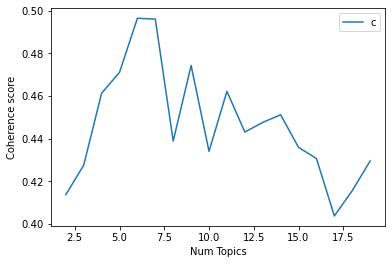

In [16]:
# plotting
limit=20; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [17]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4137
Num Topics = 3  has Coherence Value of 0.4275
Num Topics = 4  has Coherence Value of 0.4613
Num Topics = 5  has Coherence Value of 0.471
Num Topics = 6  has Coherence Value of 0.4964
Num Topics = 7  has Coherence Value of 0.496
Num Topics = 8  has Coherence Value of 0.4388
Num Topics = 9  has Coherence Value of 0.4743
Num Topics = 10  has Coherence Value of 0.434
Num Topics = 11  has Coherence Value of 0.4622
Num Topics = 12  has Coherence Value of 0.4431
Num Topics = 13  has Coherence Value of 0.4476
Num Topics = 14  has Coherence Value of 0.4512
Num Topics = 15  has Coherence Value of 0.4359
Num Topics = 16  has Coherence Value of 0.4306
Num Topics = 17  has Coherence Value of 0.4037
Num Topics = 18  has Coherence Value of 0.4156
Num Topics = 19  has Coherence Value of 0.4295


In [18]:
# make a dataframe of topic probabilities 
list_of_dics = []
for topic in corpus:
    res = lda_model[topic]
    list_of_dics.append(dict(res))
    
proba = pd.DataFrame(list_of_dics)   

In [19]:
proba

,0,1,2,3,4,5
0,0.178766,0.002900,0.152332,0.095985,0.502326,0.067691
1,0.236134,0.003154,0.452000,0.045095,0.238540,0.025077
2,0.212009,0.002781,0.603072,0.129565,0.039222,0.013350
3,0.425748,0.002254,0.421517,0.049449,0.018810,0.082222
4,0.011889,0.003395,0.647214,0.216008,0.076871,0.044623
...,...,...,...,...,...,...
4994,0.034516,0.023710,0.093855,0.405362,0.257753,0.184804
4995,0.059321,0.003285,0.146073,0.604374,0.102300,0.084647
4996,0.008180,0.003809,0.664764,0.189238,0.123672,0.010337
4997,0.004837,0.002254,0.460027,0.421561,0.090600,0.020720


In [20]:
# renaming each column after inscpeting highest scores mapped to each topic number
col0 = 'Cancer Trials'
col1 = 'Species Discovery'
col2 = 'Miscellaneous Studies'
col3 = 'Psychological Studies'
col4 = 'Emerging Technologies'
col5 = 'Drug Discovery'

proba.columns = [col0, col1, col2, col3, col4, col5]

In [21]:
# add an extra colum with selected topic according to highest probability
proba['selected_topic'] = proba.idxmax(axis=1)

In [22]:
# final shape of dataframe
proba

,Cancer Trials,Species Discovery,Miscellaneous Studies,Psychological Studies,Emerging Technologies,Drug Discovery,selected_topic
0,0.178766,0.002900,0.152332,0.095985,0.502326,0.067691,Emerging Technologies
1,0.236134,0.003154,0.452000,0.045095,0.238540,0.025077,Miscellaneous Studies
2,0.212009,0.002781,0.603072,0.129565,0.039222,0.013350,Miscellaneous Studies
3,0.425748,0.002254,0.421517,0.049449,0.018810,0.082222,Cancer Trials
4,0.011889,0.003395,0.647214,0.216008,0.076871,0.044623,Miscellaneous Studies
...,...,...,...,...,...,...,...
4994,0.034516,0.023710,0.093855,0.405362,0.257753,0.184804,Psychological Studies
4995,0.059321,0.003285,0.146073,0.604374,0.102300,0.084647,Psychological Studies
4996,0.008180,0.003809,0.664764,0.189238,0.123672,0.010337,Miscellaneous Studies
4997,0.004837,0.002254,0.460027,0.421561,0.090600,0.020720,Miscellaneous Studies


In [23]:
# adding our dataframe to the original dataset
final_df = pd.concat([df, proba], axis=1)

In [24]:
# final shape 
final_df

,ArticleID,Title,Abstract,Cancer Trials,Species Discovery,Miscellaneous Studies,Psychological Studies,Emerging Technologies,Drug Discovery,selected_topic
0,34153941,Stable Coordination Variability in Overground ...,Coordination variability (CV) is commonly anal...,0.178766,0.002900,0.152332,0.095985,0.502326,0.067691,Emerging Technologies
1,34153942,Weak Hip Strength Increases Dynamic Knee Valgu...,Clinical Scenario: Dynamic knee valgus (DKV) i...,0.236134,0.003154,0.452000,0.045095,0.238540,0.025077,Miscellaneous Studies
2,34153964,Current and Future Projections of Amyotrophic ...,Various methodologies have been reported to as...,0.212009,0.002781,0.603072,0.129565,0.039222,0.013350,Miscellaneous Studies
3,34153968,Disparities between Asian and Non-Asian Thromb...,As outcomes for acute ischemic stroke (AIS) va...,0.425748,0.002254,0.421517,0.049449,0.018810,0.082222,Cancer Trials
4,34153978,Maternal Factors Predicting Loss to Follow-Up ...,Because hearing loss in children can result in...,0.011889,0.003395,0.647214,0.216008,0.076871,0.044623,Miscellaneous Studies
...,...,...,...,...,...,...,...,...,...,...
4994,34444567,Mind the Differences: How Diagnoses and Hospit...,Integrated care pathway (ICP) is a prevailing ...,0.034516,0.023710,0.093855,0.405362,0.257753,0.184804,Psychological Studies
4995,34444568,The Ethics of Dying: Deciphering Pandemic-Resu...,The objective of medicine is to provide humans...,0.059321,0.003285,0.146073,0.604374,0.102300,0.084647,Psychological Studies
4996,34444569,Research on Adolescents Regarding the Indirect...,This research involved the participation of 30...,0.008180,0.003809,0.664764,0.189238,0.123672,0.010337,Miscellaneous Studies
4997,34444571,Pre-Intervention Effects of a Community-Based ...,This study explores the impact of the 'pre-int...,0.004837,0.002254,0.460027,0.421561,0.090600,0.020720,Miscellaneous Studies


In [27]:
# save to hard drive
final_df.to_csv('submit.csv')